# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести.**

Смена рабочей директории.

In [4]:
import os
os.chdir('D:/2023-Kufarov-TimeSeriesCourse/practice/01 Basics')

Использование команд, которые автоматически перезагружают все импортированные модули при их изменении.

In [5]:
%load_ext autoreload
%autoreload 2

## **Часть 1.** Евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация.

Импорт библиотек и модулей.

In [6]:
import numpy as np
import pandas as pd

from modules.metrics import *
from modules.utils import *
from modules.plots import *

### **Задача 1.**
Вам необходимо самостоятельно реализовать функцию `ED_distance()` в модуле *metrics.py* для нахождения евклидовой метрики между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `euclidean_distance()` из библиотеки *sktime*. В качестве входных данных используйте два синтетических временных ряда некоторой заданной вами длины, сгенерированных моделью случайных блужданий (Random Walk). Модель случайных блужданий реализуйте самостоятельно или используйте готовые реализации.

*Евклидова метрика* между временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

In [7]:
%pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [8]:
from sktime.distances import euclidean_distance
import random

def test_ed_distance(ts1, ts2):

    sktime_ed_dist = round(euclidean_distance(ts1, ts2), 5)
    desired_ed_dist = round(ED_distance(ts1, ts2), 5)

    np.testing.assert_equal(sktime_ed_dist, desired_ed_dist, 'ED distances are not equal')

In [9]:
length = 5
test_ed_distance(random_walk(length), random_walk(length))

### **Задача 2.**

Вам необходимо самостоятельно реализовать функцию `DTW_distance()` в модуле *metrics.py* для нахождения DTW меры между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `dtw_distance()` из библиотеки *sktime*. Сгенерируйте два временных ряда некоторой заданной вами длины с помощью модели случайных блужданий (Random Walk) или используйте ряды из предыдущей задачи.

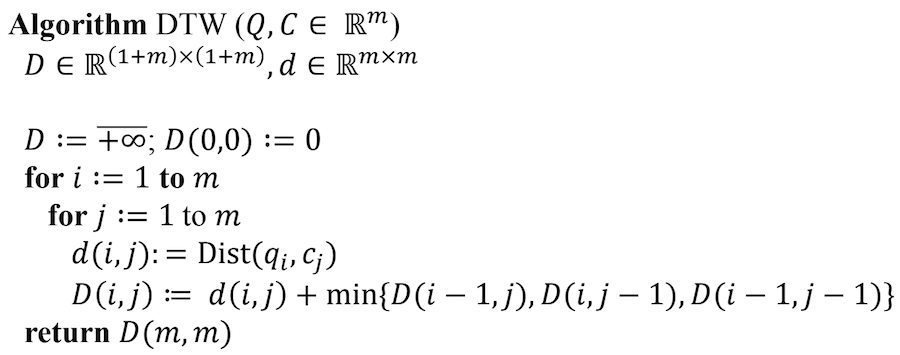

In [10]:
import random
from sktime.distances import dtw_distance

def test_dtw_distance(ts1, ts2):

    sktime_dtw_dist = dtw_distance(ts1, ts2)
    desired_dtw_dist = DTW_distance(ts1, ts2)

    np.testing.assert_equal(sktime_dtw_dist, desired_dtw_dist, 'DTW distances are not equal')

In [12]:
length = 5
test_dtw_distance(random_walk(length), random_walk(length))

### **Задача 3.**
Реализуйте функцию нахождения матрицы расстояния между временными рядами. Для вычисления расстояний между рядами используйте реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(A,B)=dist(B,A)$), то матрица расстояний будет квадратной и симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом: $dist\_matrix(j,i) = dist\_matrix(i,j)$, где $i < j$.

In [13]:
def calculate_distance_matrix(data, metric='euclidean', normalize=True):
    
    if metric=='euclidean':
        dist_func = ED_distance
    elif metric=='dtw':
        dist_func = DTW_distance
    else:
        raise ValueError("Metric must be 'euclidean' or 'dtw'.")

    N = data.shape[0] # number of time series

    # Initialize the distance matrix
    distance_matrix = np.zeros(shape=(N, N))
    
    for i in range(N):
        for j in range(i, N):
            if i == j:
                distance_matrix[i, j] = 0.0
            else:
                distance_matrix[i, j] = dist_func(data[i], data[j])
    
    distance_matrix = distance_matrix + distance_matrix.T

    return distance_matrix

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться вычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла CBF_TRAIN.txt. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2), которая записана в первом столбце, и временной ряд -- в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [14]:
def load_ts(file_name):

    ts = pd.read_csv(file_name, header=None, delim_whitespace=True)

    return ts

In [15]:
url = './datasets/part1/CBF_TRAIN.txt'

data = load_ts(url)

ts_set = data.iloc[:, 1:].to_numpy()
labels = data.iloc[:, 0].squeeze().to_numpy()

Выполните визуализацию экземпляра каждого класса. Для этого используйте функцию `plot_ts_set()` из модуля *plots.py*.

In [16]:
idxs = [list(labels).index(1), list(labels).index(2), list(labels).index(3)]
plot_ts_set(pd.DataFrame(ts_set).iloc[idxs].to_numpy())

Далее вам необходимо самостоятельно реализовать класс для выполнения иерархической кластеризации временных рядов.

Перед тем как приступить к его реализации, изучите скелет класса `TimeSeriesHierarchicalClustering`, который представлен в модуле *clustering.py*. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию AgglomerativeClustering из *sklearn*.   

Протестируйте свою реализацию иерархической кластеризации на наборе данных CBF для двух метрик: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами и передайте их в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [17]:
from modules.clustering import *

#### euclidean

In [18]:
dist_marix = calculate_distance_matrix(ts_set, metric='euclidean')
model = TimeSeriesHierarchicalClustering(n_clusters=3).fit(dist_marix)

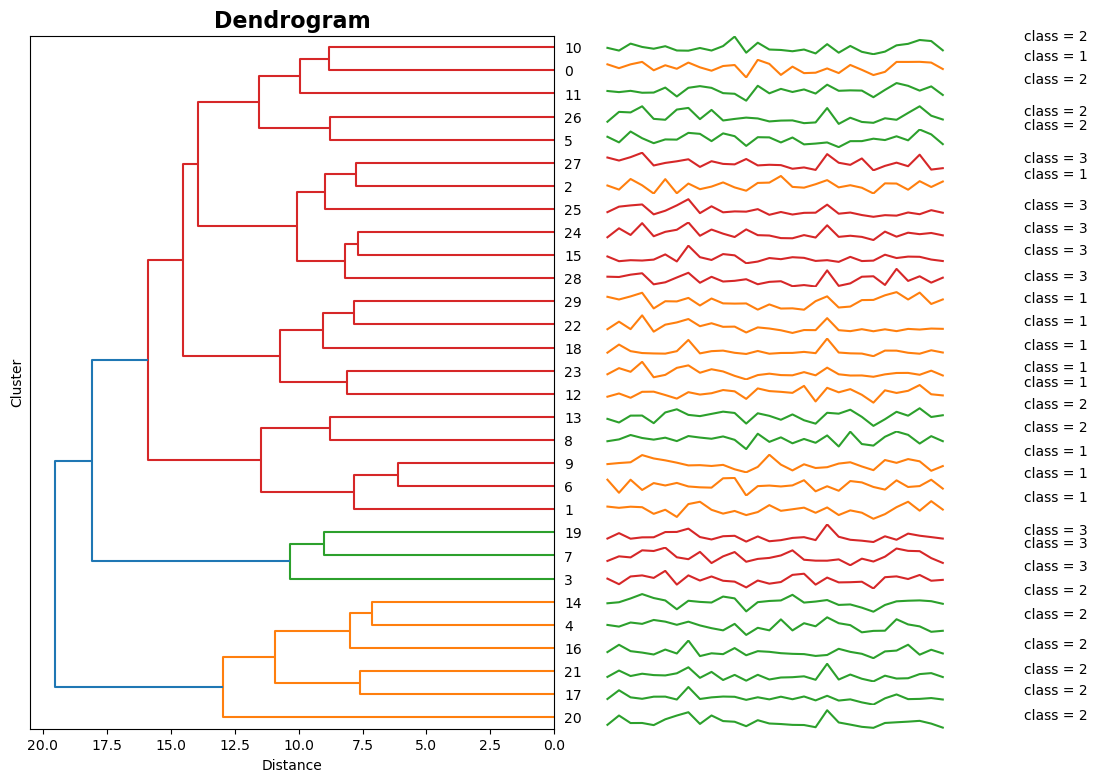

In [19]:
model.plot_dendrogram(pd.DataFrame(ts_set), labels)

#### dtw

In [20]:
dist_marix = calculate_distance_matrix(ts_set, metric='dtw')
model = TimeSeriesHierarchicalClustering(n_clusters=3).fit(dist_marix)

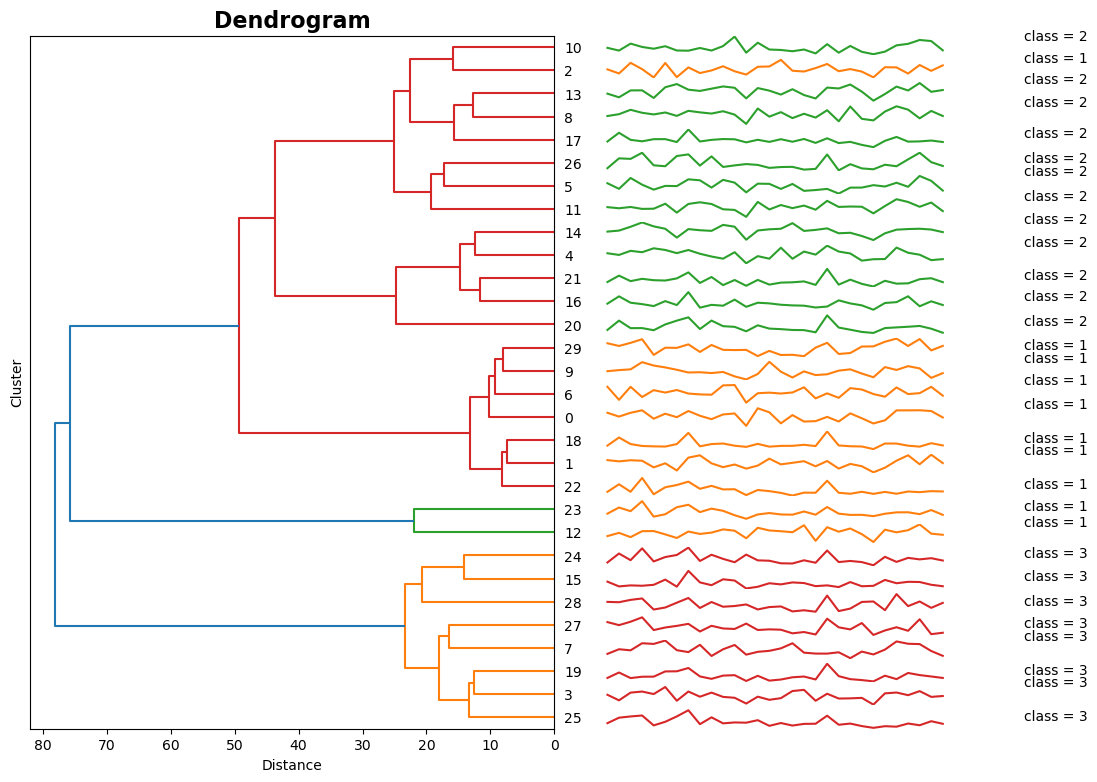

In [21]:
model.plot_dendrogram(pd.DataFrame(ts_set), labels)

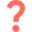
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм. Какая на ваш взгляд метрика/мера показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать меру DTW, чем метрику Евклида.

**Евклидово расстояние интуитивно понятно и у этой метрики ниже вычислительная сложность, однако работает только для рядов одинаковой длины и не учитывает форму рядов. DTW, напротив, учитывает форму рядов, а также может работать с рядами разной длины, но вычислительно сложнее.**